<div style="color:white;
           display:fill;
           border-radius:2px;
           background-color:cyan;
           font-size:250%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
          text-align: center;
          font-size:150%;
          color:brown;">
           🎨Embeddings📊
</p>
<style>
        h1{text-align: center;}
 </style>  
    
</div> 

<div style="background-color: black; padding: 20px; border-radius: 10px; margin: 20px auto; max-width: 600px;">
    <center>
        <div style="background-color: White; padding: 20px; border-radius: 10px;">
            <b style="font-size: 24px; color: #ff6600;">👏😊 &nbsp; IF YOU FIND THIS HELPFUL, PLEASE UPVOTE! &nbsp; 💢👏</b>
            <div style="margin-top: 20px; font-size: 18px; color: black;">
                🏆🏆receiving your appreciation means a lot to me! 😅🎃 Your upvotes inspire me to keep creating helpful content like this🖥🍱.
            </div>
        </div>
    </center>
</div>


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:skyblue;
           font-size:250%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:blue;">
           📚📚About The Dataset 🧾📑
</p>
<style>
        h1{text-align: center;}
 </style>  

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:cyan;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
    The dataset presented here is drawn from the Kolibri Studio curricular alignment tool, in which users can create their own channel, then build out a topic tree that represents a curriculum taxonomy or other hierarchical structure, and finally organize content items into these topics, by uploading their own content and/or importing existing materials from the Kolibri Content Library of Open Educational Resources.
An example of a branch of a topic tree is: Secondary Education >> Ordinary Level >> Mathematics >> Further Learning >> Activities >> Trigonometry. The leaf topic in this branch might then contain (be correlated with) a content item such as a video entitled Polar Coordinates.
You are challenged to predict which content items are best aligned to a given topic in a topic tree, with the goal of matching the selections made by curricular experts and other users of the Kolibri Studio platform. In other words, your goal is to recommend content items to curators for potential inclusion in a topic, to reduce the time they spend searching for and discovering relevant content to consider including in each topic.
The full test set includes an additional 10,000 topics (none present in the training set) and a large number of additional content items. The additional content items are only correlated to test set topics.
topics.csv - Contains a row for each topic in the dataset. These topics are organized into "channels", with each channel containing a single "topic tree" (which can be traversed through the "parent" reference). Note that the hidden dataset used for scoring contains additional topics not in the public version. You should only submit predictions for those topics listed in sample_submission.csv.
content.csv - Contains a row for each content item in the dataset. Note that the hidden dataset used for scoring contains additional content items not in the public version. These additional content items are only correlated to topics in the test set. Some content items may not be correlated with any topic.
</p>
</div>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:skyblue;
           font-size:250%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:black;">
           📚📚Importing Libraries<span style='font-size:50px;'>&#128295;</span>
</p>
<style>
        h1{text-align: center;}
 </style>  

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:cyan;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:black;">
          Thanks to : https://www.kaggle.com/code/erenakbulut/language-model-minilm-l12-v2/notebook
</p>
<style>
        h1{text-align: center;}
 </style>  
    
</div>


In [ ]:
!pip install cupy

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from transformers import AutoTokenizer, AutoModel
import cupy as cp
from cuml.metrics import pairwise_distances

device = "cuda" if torch.cuda.is_available() else "cpu"
%env TOKENIZERS_PARALLELISM=true

import os
for dirname, _, filenames in os.walk('/kaggle/input/learning-equality-curriculum-recommendations'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:cyan;
           font-size:200%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:brown;">
          <span style='font-size:50px;'>&#128229;</span> Loading the dataset<span style='font-size:50px;'>&#128160;</span>
</p>
<style>
        h1{text-align: center;}
 </style>  
    
</div>

In [ ]:
class CFG:
    INPUT = '/kaggle/input/learning-equality-curriculum-recommendations'
    MODEL = '/kaggle/input/sentence-embedding-models/paraphrase-MiniLM-L12-v2'
    MAX_LEN = 384
    SELECT_TOP_N = 5

In [ ]:
content_df = pd.read_csv(f'{CFG.INPUT}/content.csv')
correlations_df = pd.read_csv(f'{CFG.INPUT}/correlations.csv')
topics_df = pd.read_csv(f'{CFG.INPUT}/topics.csv')
sub_df = pd.read_csv(f'{CFG.INPUT}/sample_submission.csv')

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:cyan;
           font-size:200%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:black;">
          <span style='font-size:50px;'>&#128229;</span> Model Reading from Hugging Face<span style='font-size:50px;'>&#128160;</span>
</p>
<style>
        h1{text-align: center;}
 </style>  
    
</div>

In [ ]:
model = AutoModel.from_pretrained(CFG.MODEL)
model.eval()
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL)

In [ ]:
from tqdm.auto import tqdm


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:cyan
            ;
           font-size:200%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:black;">
          <span style='font-size:50px;'>&#128229;</span> Vector Creation<span style='font-size:50px;'>&#128160;</span>
</p>
<style>
        h1{text-align: center;}
 </style>  
    
</div>

In [ ]:
vecs = []
for _, row in tqdm(content_df.iterrows(), total=len(content_df)):
    title = row['title']
    if type(title) is float:
        title = row['description']
    if type(title) is float:
        title = row['text']
    
    tok = tokenizer(title)
    for k, v in tok.items():
        tok[k] = torch.tensor(v[:CFG.MAX_LEN]).to(device).unsqueeze(0)
    with torch.no_grad():
        output = model(**tok)
    vec = output.last_hidden_state.squeeze(0).mean(0).cpu()
    vecs.append(vec)
    
vecs1 = torch.stack(vecs)

In [ ]:
sub_topic_ids = sub_df['topic_id'].tolist()
_topics_df = topics_df.query(f'id in {sub_topic_ids}')

In [ ]:
vecs = []
for _, row in tqdm(_topics_df.iterrows(), total=len(_topics_df)):
    title = row['title']
    if type(title) is float:
        title = row['description']
    if type(title) is float:
        title = "This content contains no text."
    
    tok = tokenizer(title)
    for k, v in tok.items():
        tok[k] = torch.tensor(v[:CFG.MAX_LEN]).to(device).unsqueeze(0)
    with torch.no_grad():
        output = model(**tok)
    vec = output.last_hidden_state.squeeze(0).mean(0).cpu()
    vecs.append(vec)
    
vecs2 = torch.stack(vecs)

In [ ]:
vecs1 = cp.asarray(vecs1)
vecs2 = cp.asarray(vecs2)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:cyan;
           font-size:200%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:black;">
          <span style='font-size:50px;'>&#128229;</span> Prediction through Model<span style='font-size:50px;'>&#128160;</span>
</p>
<style>
        h1{text-align: center;}
 </style>  
    
</div>


In [ ]:
predicts = []
for v2 in vecs2:
    sim = pairwise_distances(v2.reshape(1, len(v2)), vecs1, metric='cosine')
    p = " ".join([content_df.loc[s, 'id'] for s in sim.argsort(1)[0, :CFG.SELECT_TOP_N].get()])
    predicts.append(p)

In [ ]:
sub_df['content_ids'] = predicts
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv', index=None)


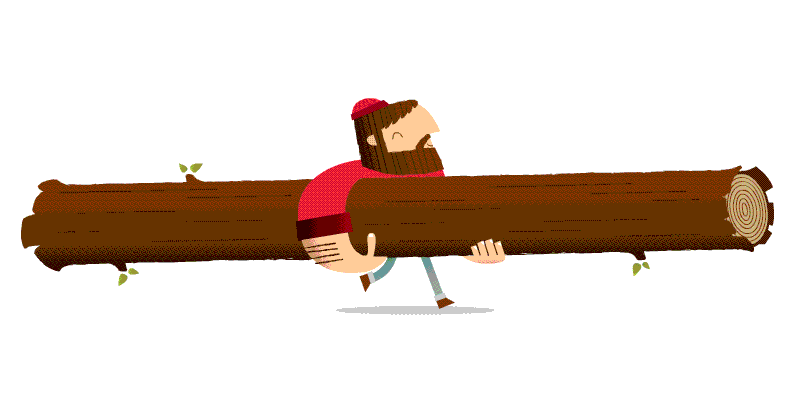

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:Orange;
           font-size:200%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding:3px;
          text-align: center;
          font-size:150%;
          color:black;">
          <span style='font-size:50px;'>&#128229;</span> Feel Free to Modify and Looking for Suggestion to improve <span style='font-size:50px;'>&#128160;</span>
</p>
<style>
        h1{text-align: center;}
 </style>  
    
</div>
​
